## Predict Product Category from Invoice

In [107]:
# Import the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Gathering the data from the provided .csv files 

In [108]:
# Read the training dataset from a .csv file to a dataframe
df1 = pd.read_csv('dataset/Train.csv')
df1.head()

,Inv_Id,Vendor_Code,GL_Code,Inv_Amt,Item_Description,Product_Category
0,15001,VENDOR-1676,GL-6100410,83.24,Artworking/Typesetting Production Jun 2009 Cha...,CLASS-1963
1,15002,VENDOR-1883,GL-2182000,51.18,Auto Leasing Corporate Services Corning Inc /N...,CLASS-1250
2,15004,VENDOR-1999,GL-6050100,79.02,Store Management Lease/Rent Deltona Corp Real ...,CLASS-1274
3,15005,VENDOR-1771,GL-6101400,48.50,Store Construction General Requirements Coloni...,CLASS-1522
4,15006,VENDOR-1331,GL-2182000,63.35,Jul 2015 Aydin Corp Contingent Labor/Temp Labo...,CLASS-1376


### Exploring and Cleaning the data for further analysis purpose

In [109]:
# Check for wrong datatypes and missing values
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5566 entries, 0 to 5565
Data columns (total 6 columns):
Inv_Id              5566 non-null int64
Vendor_Code         5566 non-null object
GL_Code             5566 non-null object
Inv_Amt             5566 non-null float64
Item_Description    5566 non-null object
Product_Category    5566 non-null object
dtypes: float64(1), int64(1), object(4)
memory usage: 261.0+ KB


In [110]:
# Check for duplicate data
sum(df.duplicated())

0

In [111]:
# Check for outliers or any other statistical info
df1.describe()

,Inv_Id,Inv_Amt
count,5566.000000,5566.000000
mean,19010.787100,49.980151
std,2306.607485,28.903030
min,15001.000000,0.010000
25%,17006.250000,24.957500
50%,19017.500000,49.645000
75%,20994.750000,75.170000
max,23012.000000,99.990000


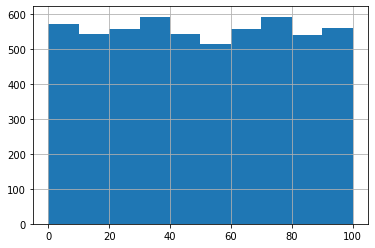

In [112]:
# Check the distribution of Inv_Amt
df1['Inv_Amt'].hist();

In [113]:
# Investigate the column 'Item_Description' and search for any pattern or incorrect data
for i in range(10):
    print ((df1['Item_Description'].iloc[i]))

Artworking/Typesetting Production Jun 2009 Champion Parts Inc SMAP Prototype and Comp Production/Packaging Design
Auto Leasing Corporate Services Corning Inc /Ny 2013-Mar  Auto Leasing and Maintenance Other Corporate Services
Store Management Lease/Rent Deltona Corp Real Estate Base Rent Jul2018
Store Construction General Requirements Colonial Trust Iii General Contractor Final Site Clean Up 2005-Dec 
Jul 2015 Aydin Corp Contingent Labor/Temp Labor Contingent Labor/Temp Labor Corporate Services Human Resources
Final Site Clean Up 2018Mar Store Construction Dravo Corp General Contractor General Requirements
Travel and Entertainment Miscellaneous Company Car (Field Only) Texas New Mexico Power Co Ground Transportation Miscellaneous Company Car (Field Only) 2011-Mar 
General Contractor General Requirements Final Site Clean Up American Pad & Paper Co Apr2014 Store Construction
Aquila Distributors Inc                                 /Bd Prototype and Comp Production/Packaging Design Jul 200

In [114]:
# Check for the unique Product catergories assigned in the training data
df_train.Product_Category.unique()

array(['CLASS-1963', 'CLASS-1250', 'CLASS-1274', 'CLASS-1522',
       'CLASS-1376', 'CLASS-1758', 'CLASS-2141', 'CLASS-1429',
       'CLASS-1652', 'CLASS-1249', 'CLASS-1721', 'CLASS-1870',
       'CLASS-1828', 'CLASS-2112', 'CLASS-1567', 'CLASS-1309',
       'CLASS-1477', 'CLASS-1805', 'CLASS-1919', 'CLASS-1322',
       'CLASS-1838', 'CLASS-2015', 'CLASS-1850', 'CLASS-2003',
       'CLASS-1248', 'CLASS-1964', 'CLASS-2241', 'CLASS-1867',
       'CLASS-1983', 'CLASS-1294', 'CLASS-1688', 'CLASS-2038',
       'CLASS-1770', 'CLASS-2152', 'CLASS-2146', 'CLASS-1957'],
      dtype=object)

**The overall dataset looks clean with no missing values and duplicates. Whereas the `Item_Description` column looks messy. Hence it needs to be cleaned before proceeding to any further analysis/prediction with the given data.**

In [115]:
# Import libraries for pre-processing the text data
import re
import nltk
from nltk.corpus import stopwords

In [116]:
REPLACE_WITH_SPACE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))
ELLIPSIS = re.compile('[\.\.\.]')
CURRENCY_PERCN = re.compile('[\$?\d+(?:\.\d+)?%?]')
ABBERV = re.compile('[\(?:[A-Z]\.\)+]')

"""
    method: clean_text() | pre-processing/cleaning the raw Item_Description provided in the dataset
    argument: text       | a string
    return: text         | modified initial string
"""
def clean_text(text):
    text = text.lower() # lowercase text
    text = REPLACE_WITH_SPACE.sub(' ', text) # replace symbols by space in text
    text = BAD_SYMBOLS.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ELLIPSIS.sub('', text) # delete any ellipsis present in the data
    text = CURRENCY_PERCN.sub(' ',text) # replace any currency or percentage with a space
    text = ABBERV.sub(' ', text) # replace any abbreviation with a space
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwords from text
    return text

In [117]:
# Copy the original dataframe to a new dataframe for modification
df_train = df1.copy()

In [118]:
# Pre-process/CLean the Item_Description values using clean_text() method
df_train['Item_Description'] = df['Item_Description'].apply(clean_text)

In [119]:
# Check the cleaned text data
for i in range(10):
    print ((df_train['Item_Description'].iloc[i]))

artworking typesetting production jun champion parts inc smap prototype comp production packaging design
auto leasing corporate services corning inc ny mar auto leasing maintenance corporate services
store management lease rent deltona corp real estate base rent jul
store construction general requirements colonial trust iii general contractor final site clean dec
jul aydin corp contingent labor temp labor contingent labor temp labor corporate services human resources
final site clean mar store construction dravo corp general contractor general requirements
travel entertainment miscellaneous company car field texas new mexico power co ground transportation miscellaneous company car field mar
general contractor general requirements final site clean american pad paper co apr store construction
aquila distributors inc bd prototype comp production packaging design jul artworking typesetting production smap
base rent store management chicago rivet machine co dec lease rent real estate


**The cleaned `Item_Description` is our feature data and `Product_Category` is our label/target data. Both this data needs to be in numeric form in order to trin a classifier using them, but both are of 'object' datatype and needs to be converted to numeric form**

### Training ML models using the Cleaned dataset

In [120]:
# split the training datatset into training and testing dataset
from sklearn.model_selection import train_test_split

X = df_train.Item_Description
y = df_train.Product_Category
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)

**After cleaning/pre-processing the text data and then splitting the dataset, the next step is feature engineering. The text data needs to be converted to a matrix of token counts (CountVectorizer), then transform a count matrix to a normalized Tf-idf representation (tf-idf transformer).**

**Applying feature engineering to the features and labels, classifier needs to be trained with the numeric data. To find the most efficient and accurate model three different ML models are used for training and testing on the dataset.**
- Multinomial Naive Bayes' CLassifier
- Logistic Regression
- Linear Support Vector Machine

**Using Multinomial Naive Bayes' CLassifier for prediction**

In [121]:
# Import the necessary libraries
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB

nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
nb.fit(X_train, y_train)

y_pred = nb.predict(X_test)
print('accuracy %s' % metrics.accuracy_score(y_pred, y_test))

accuracy 0.9556886227544911


**Using Logistic Regression for prediction**

In [122]:
from sklearn.linear_model import LogisticRegression

logreg = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=1, C=1e5, multi_class='auto', solver='lbfgs')),
               ])
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)

print('accuracy %s' % metrics.accuracy_score(y_pred, y_test))

accuracy 0.9970059880239521


**Using Linear Support Vector Machine for prediction**

In [123]:
from sklearn.linear_model import SGDClassifier

sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
               ])
sgd.fit(X_train, y_train)

y_pred = sgd.predict(X_test)

print('accuracy %s' % metrics.accuracy_score(y_pred, y_test))

accuracy 0.9940119760479041


**After training all the three models using the train dataset it is observed that a Logistic Regression Model gives us the most accuracy of 99.7%. Hence the prediction of `Product_Category` for the provided test data in .csv file is done using the Logistic Regression Model.** 

In [124]:
# Read the test data from a .csv file to a dataframe
df_test=pd.read_csv('dataset/Test.csv')
df_test['Item_Description']=df_test['Item_Description'].apply(clean_text)

In [125]:
# Get predicted Product_Category values from pretrained Logistic Regression model
df_test['Product_Category']=pd.Series(logreg.predict(df_test['Item_Description']))
df_test.head(10)

,Inv_Id,Vendor_Code,GL_Code,Inv_Amt,Item_Description,Product_Category
0,15003,VENDOR-2513,GL-6050310,56.13,travel entertainment miscellaneous company car...,CLASS-1758
1,15008,VENDOR-1044,GL-6101400,96.56,final site clean store construction advanced m...,CLASS-1522
2,15013,VENDOR-1254,GL-6101400,55.93,arabian american development co final site cle...,CLASS-1522
3,15019,VENDOR-1331,GL-2182000,32.62,corporate services contingent labor temp labor...,CLASS-1376
4,15020,VENDOR-2513,GL-6050310,25.81,fortune national corp miscellaneous company ca...,CLASS-1758
5,15022,VENDOR-2513,GL-6050310,22.71,dec fortune national corp miscellaneous compan...,CLASS-1758
6,15024,VENDOR-1883,GL-2182000,47.38,auto leasing corporate services corning inc ny...,CLASS-1250
7,15026,VENDOR-2543,GL-6020600,26.08,taxes taxes mar frischs restaurants inc nonpro...,CLASS-2146
8,15027,VENDOR-1944,GL-2182000,42.76,daly john j auto fleet repair maintenance jun ...,CLASS-1249
9,15028,VENDOR-2032,GL-6100500,70.47,smap media buy traditional cgg holding us inc ...,CLASS-1850


In [126]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2446 entries, 0 to 2445
Data columns (total 6 columns):
Inv_Id              2446 non-null int64
Vendor_Code         2446 non-null object
GL_Code             2446 non-null object
Inv_Amt             2446 non-null float64
Item_Description    2446 non-null object
Product_Category    2446 non-null object
dtypes: float64(1), int64(1), object(4)
memory usage: 114.7+ KB


In [127]:
# Assign the 'Inv_Id' and 'predicted_product_category' from test dataframe to a new result dataframe
df_result = df_test[['Inv_Id', 'Product_Category']]
df_result.head()

,Inv_Id,Product_Category
0,15003,CLASS-1758
1,15008,CLASS-1522
2,15013,CLASS-1522
3,15019,CLASS-1376
4,15020,CLASS-1758


In [128]:
# Store the predicted output to a new .csv file named 'Predicted_Product_Category.csv'
df_result.to_csv('Predicted_Product_Category.csv', index=False)